In [1]:
import os, mea
import numpy as np
from utilsEphys import *
import scipy.stats as spst
import matplotlib.pyplot as plt
from detect_peaks import detect_peaks
from scipy.ndimage import gaussian_filter1d
from bokeh.io import output_notebook, show
from bokeh.plotting import figure
output_notebook()
plt.rcParams['font.family'] = 'DeJavu Serif'
plt.rcParams['font.serif'] = ['Times New Roman']
%matplotlib notebook 

Loading BokehJS ...

## Theta peak detection from a channel in the fissure

In [2]:
behavstart = 603
behavend = 2425
dirname = r'/media/rajat/mcnlab_store2/Research/SPrecordings/Rajat_Data/Data-BackwardExpansion/SWIL14'

In [3]:
# 1. load LFP data
fs=1250.0 # sampling rate
sig = np.load(os.path.join(dirname,'SWIL14_lfp_fs24.npy'), mmap_mode='r')
sig = sig[17,int(behavstart*fs):int(behavend*fs)]
times = behavstart+np.arange(0, len(sig)/fs, 1/fs)

In [4]:
# 2. bandpass filter 6-10 Hz
frange = [5,10]
sig_filt = -mea.get_bandpass_filter_signal(sig, fs, frange)

In [5]:
# 3. detect theta peaks based on amplitude cutoff

#amplitude threshold for peak detection
ampthresh = np.mean(sig_filt) + 0.7*np.std(sig_filt)

#detect peak indices. min peak height = ampthresh, min peak distance = fs/11
thetapkind = detect_peaks(sig_filt, mph=ampthresh, mpd=int(fs/11.))

#calculate the amplitude and time for theta peak
thetapeakamp = sig_filt[thetapkind]
thetapeaktime = times[thetapkind]

p = figure(sizing_mode="stretch_width",height=250)
p.line(times, sig, legend_label="raw", color='black')
p.line(times, sig_filt, legend_label="filtered", color='blue')
p.scatter(thetapeaktime, thetapeakamp, color='red')
p.xaxis.axis_label = "Time (s)"
p.yaxis.axis_label = "Amplitude"
p.x_range.start=5
p.x_range.end=15
show(p)

# Load position, speed, and trial timestamps

In [6]:
# 1. load position
trialTs = []
speed = []
behavts = []
pos = []
omap = np.load(os.path.join(dirname,'Behavior','hall1_session1_occmap.npy'), allow_pickle=True)
omap = omap.item()
for i in range(1,len(omap)+1):
    if omap[i]['intantime'][0]>=behavstart and omap[i]['intantime'][-1]<=behavend:
        pos.extend(omap[i]['pos'])
        speed.extend(omap[i]['speed'])
        behavts.extend(omap[i]['intantime'])
        trialTs.append([omap[i]['intantime'][0], omap[i]['intantime'][-1]])
pos = np.array(pos)
speed = np.array(speed)
behavts = np.array(behavts)
trialTs = np.array(trialTs)

# Load spike data, ratemaps, ratemaps across trials for behavior

In [7]:
# 1. load spike times during behavior and calculate mean firing rate
spikets = np.load(os.path.join(dirname,'HCspikesorted','spiketimes.npy'), allow_pickle='True')
cluid = np.load(os.path.join(dirname,'HCspikesorted','spikeClusterID.npy'), allow_pickle='True')
#spikets = np.load('spikets.npy', allow_pickle=True)
#cluid = np.load('cluid.npy', allow_pickle=True)
spiketimes = []
meanfr = []
total_time = behavend - behavstart
for spk in spikets:
    spk = spk[(spk>=behavstart) & (spk<=behavend)]
    spiketimes.append(spk)
    meanfr.append(len(spk)/total_time)
spiketimes = np.array(spiketimes)
meanfr = np.array(meanfr)

plt.figure(figsize=(9,4))
for i, spiketrain in enumerate(spiketimes):
    t = np.array(spiketimes[i])
    plt.scatter(t, i * np.ones_like(t), c='k', marker='|')
plt.xlim([behavstart, behavstart+10])
plt.ylabel('Cell ID', fontsize=16)
plt.title('Spike Raster', fontsize=16)
plt.tight_layout()
plt.show()

In [8]:
# 2. load smooth rate maps for each hallway
popratemap = []
removeidx = []
for c, cid in enumerate(cluid):
    fname = os.path.join(dirname,'analyzed','RatemapsHC','ClustId'+str(cid)+'_hall1_processed.mat')
    if os.path.exists(fname):
        dat = spio.loadmat(fname)
        if len(dat['smoothratemap1d'][0])>5:
            popratemap.append(dat['smoothratemap1d'][0])
        else:
            removeidx.append(c)
    else:
        removeidx.append(c)
popratemap = np.array(popratemap)
spiketimes = np.delete(spiketimes, removeidx)
cluid = np.delete(cluid, removeidx)
meanfr = np.delete(meanfr, removeidx)

In [9]:
# 3. subset cells with meanfr > 0.05Hz and meanfr < 5Hz
spiketimes = spiketimes[(meanfr>=0.05) & (meanfr<=5)]
cluid = cluid[(meanfr>=0.05) & (meanfr<=5)]
popratemap = popratemap[(meanfr>=0.05) & (meanfr<=5),:]
meanfr = meanfr[(meanfr>=0.05) & (meanfr<=5)]

In [10]:
# 4. spike timestamps and spike position across trials
spktstrial = []
spkpostrial = []
for hts in trialTs:
    spktrial = []
    postrial = []
    for s,spkt in enumerate(spiketimes):
        spktrial.append(spkt[np.where((spkt>=hts[0]) & (spkt<=hts[-1]))[0]])
        post = []
        spkt = spkt[np.where((spkt>=hts[0]) & (spkt<=hts[-1]))[0]]
        for st in spkt:
            idx, _ = find_ge(behavts, st)
            if np.isnan(idx):
                post.append(np.nan)
            else:
                post.append(pos[idx])
        postrial.append(np.array(post))
    spkpostrial.append(np.array(postrial))
    spktstrial.append(np.array(spktrial))
spktstrial = np.array(spktstrial)
spkpostrial = np.array(spkpostrial)

<IPython.core.display.Javascript object>


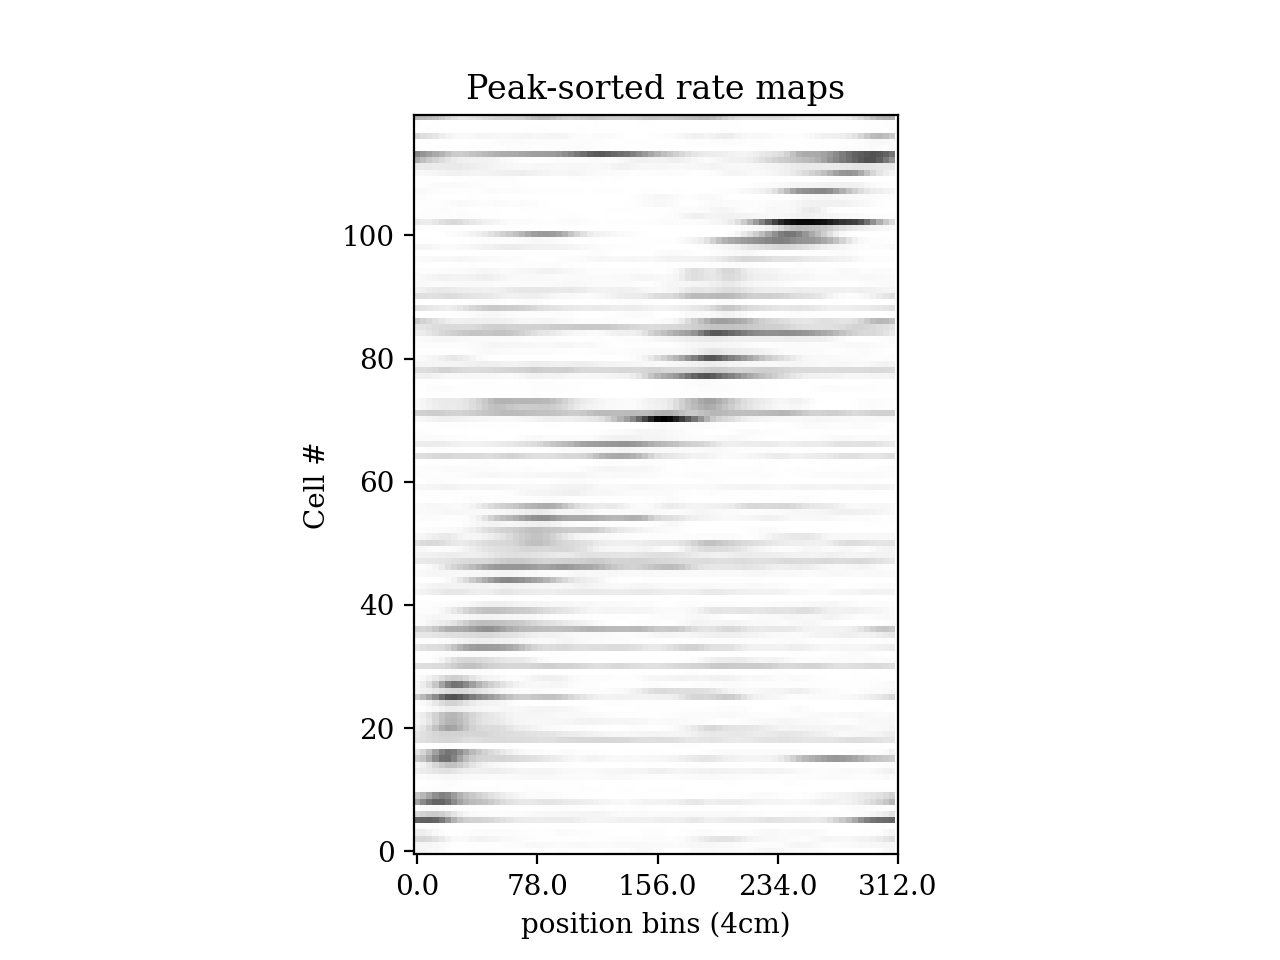

In [11]:
# 5. cell sorting order and field center for each neuron
ccenter = np.argmax(popratemap,1)
corder = np.argsort(np.argmax(popratemap,1))
plt.imshow(popratemap[corder,:], cmap='binary',origin='lower')
plt.xticks(np.linspace(0,78,5),np.linspace(0,78,5)*4)
plt.ylabel('Cell #')
plt.xlabel('position bins (4cm)')
plt.title('Peak-sorted rate maps')
plt.show()

# Calculate theta phase modulation for each cell and population

In [12]:
# 1. calculate theta phase, TMI for each cell
bins = np.arange(0,720+10,10)
spikephase = []
thetamod = []
prefangle = []
tmi = []
spiketimesSp = []
for s,spk in enumerate(spiketimes):
    spkphase = np.array(phase_assignment(thetapeaktime,spk,None,None))
    # removing spike phase with speed<5cm/s
    for p,spkt in enumerate(spk):
        ind, _ = find_ge(behavts, spkt)
        if np.isnan(ind):
            spkphase[p] = np.nan
            spk[p] = np.nan
        elif np.isnan(speed[ind]) or speed[ind]<=5:
            spkphase[p] = np.nan
            spk[p] = np.nan
    spiketimesSp.append(spk)    
    spikephase.append(spkphase)
    # for plotting double cycle
    spkphase = np.concatenate([spkphase,spkphase+360])
    # theta modulation index calculation
    n, _ = np.histogram(spkphase, bins)
    n = n/np.nanmax(n)
    n = gaussian_filter1d(n,0.5) # need to play with this
    thetamod.append(n)
    tmi.append(1-np.nanmin(n))
    # preferred theta locking angle (NOTE this includes precessing cells)
    # TMIc for precessing cells (Bishnoi et al., 2022)
    prefangle.append(bins[np.argmax(n)])
spiketimesSp = np.array(spiketimesSp)
prefangle = np.array(prefangle)
spikephase = np.array(spikephase)
thetamod = np.array(thetamod)
tmi = np.array(tmi)

<IPython.core.display.Javascript object>


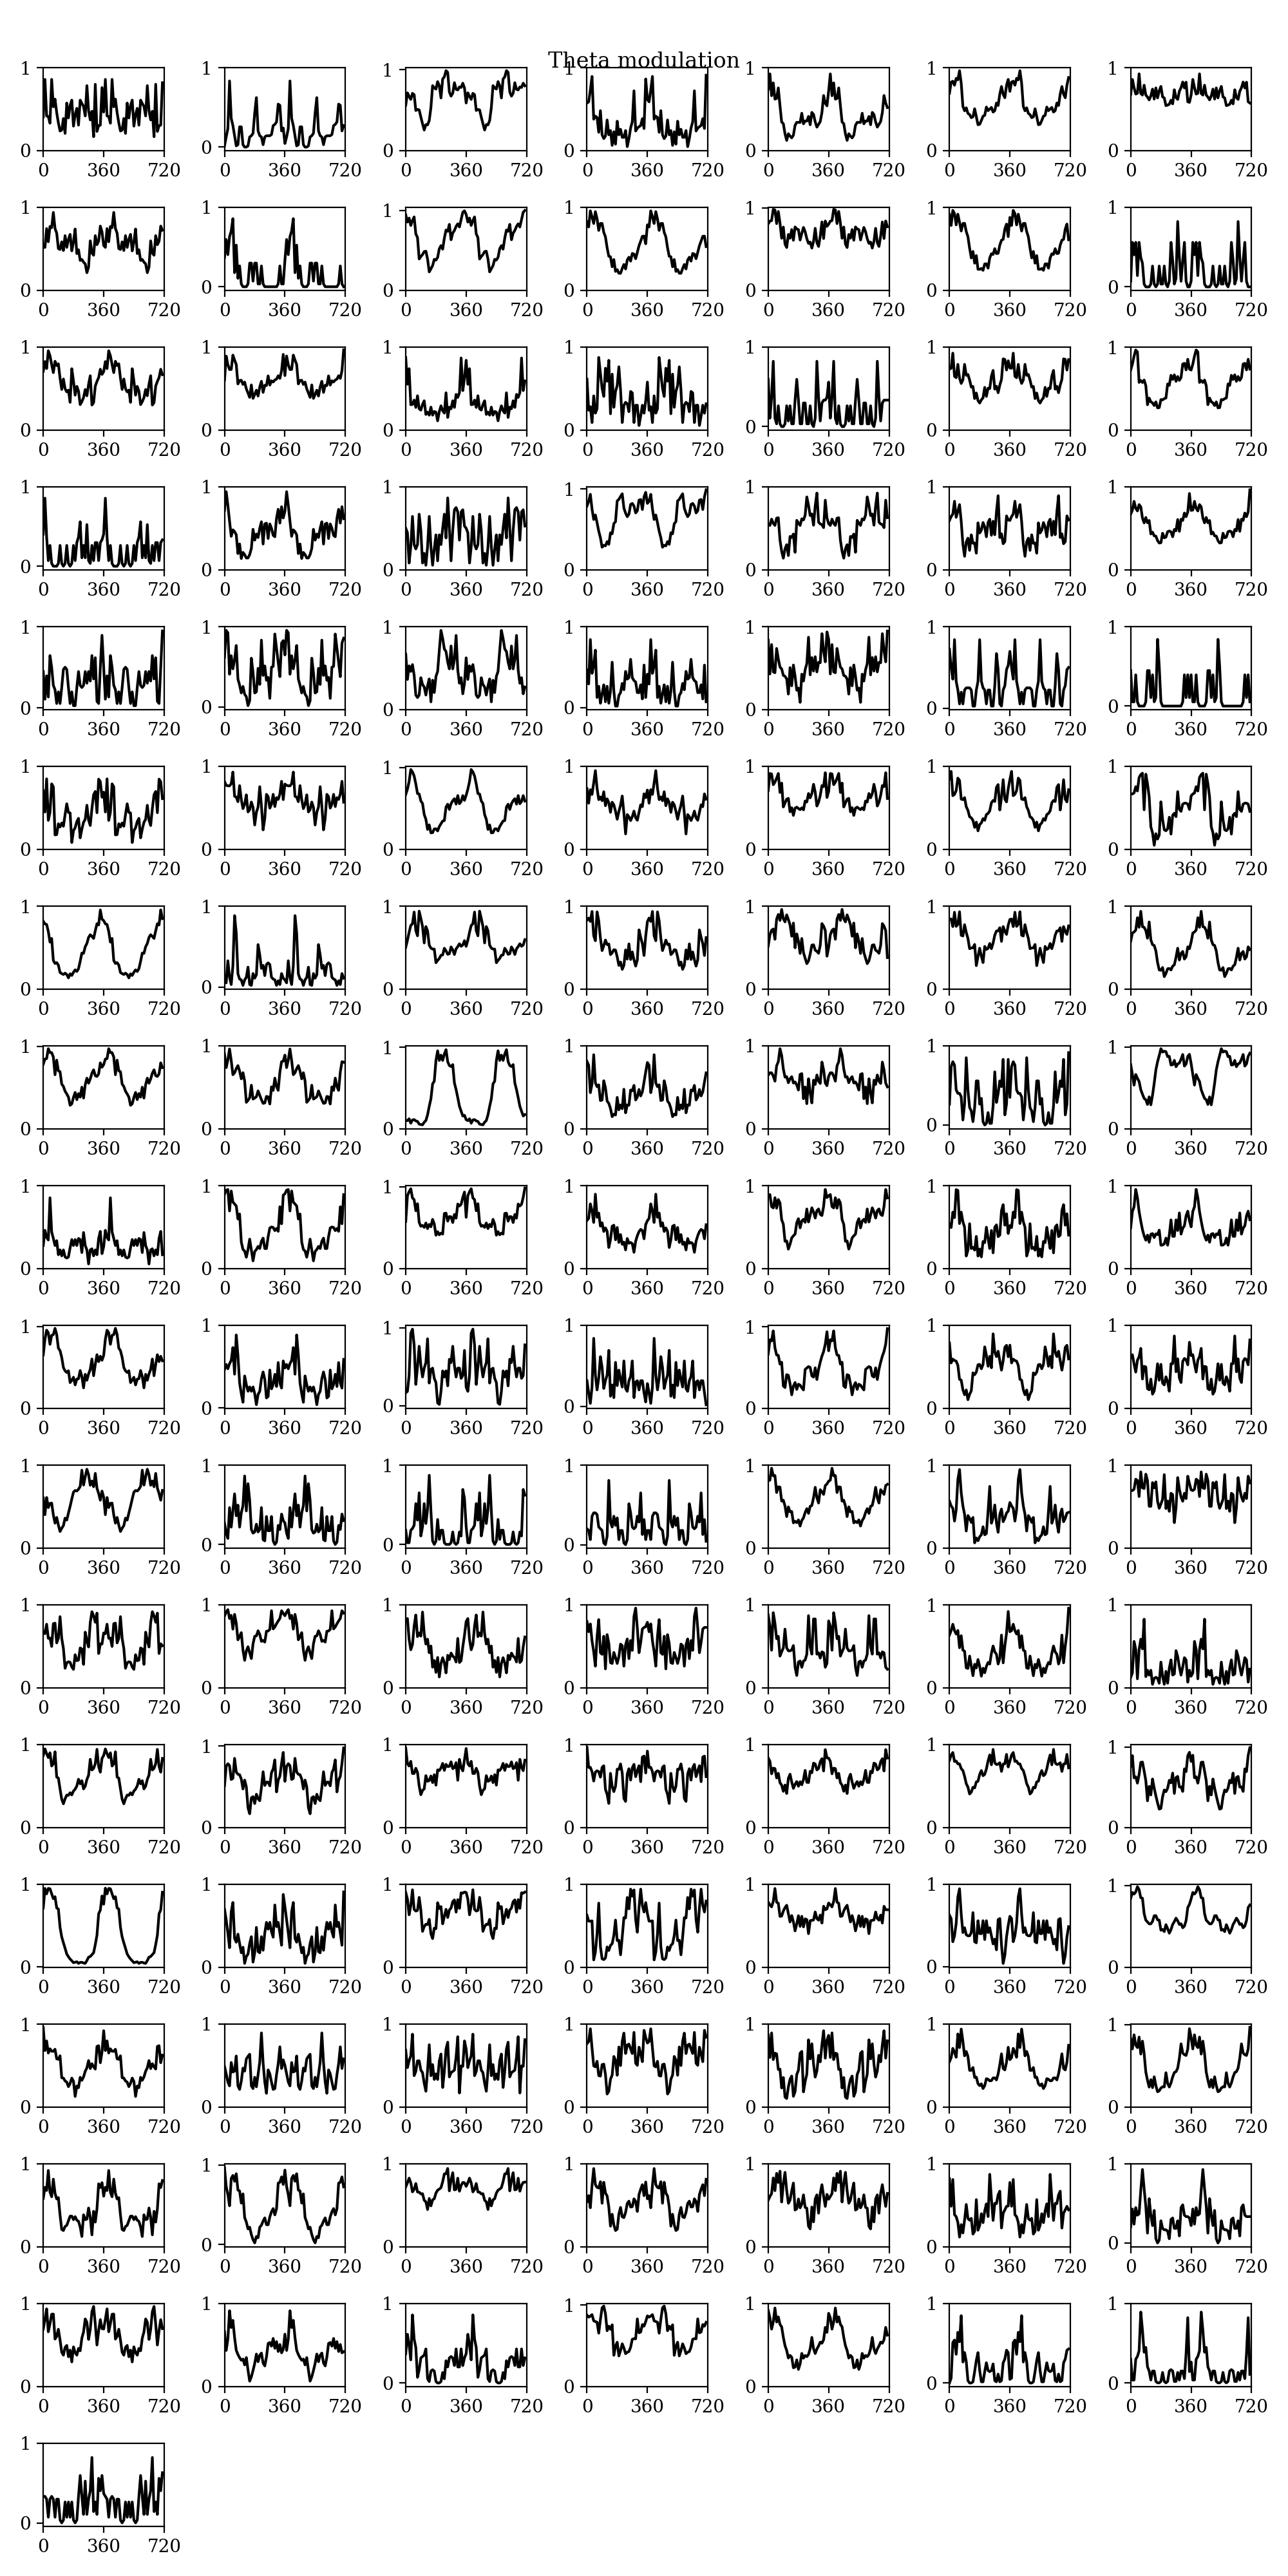

In [13]:
plt.figure(figsize=(10,20))
for t,tm in enumerate(thetamod):
    plt.subplot(18,7,t+1)
    plt.plot(bins[:-1],tm,c='k')
    plt.yticks([0,1])
    plt.xticks([0,360,720])
    plt.xlim([0,720])
plt.suptitle('Theta modulation')
plt.tight_layout()
plt.show()

<IPython.core.display.Javascript object>


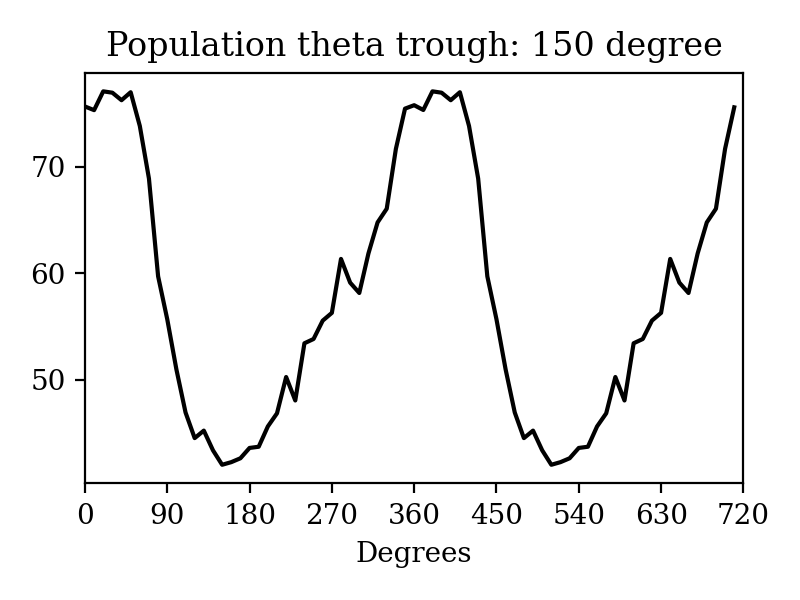

In [14]:
# 2. calculate theta modulation for the population
# this should help us determine the point of maximum inhibition 
# which will act as our reference to mark theta cycles
popthetamod = np.nansum(thetamod,0)
poptroughangle = np.mod(bins[np.argmin(popthetamod)], 360) # see how binwidth affects this?
plt.figure(figsize=(4,3))
plt.plot(bins[:-1], popthetamod, 'k')
plt.xticks(np.arange(0,720+90,90))
plt.xlim([0,720])
plt.xlabel('Degrees')
plt.title('Population theta trough: '+str(poptroughangle)+' degree')
plt.tight_layout()
plt.show()

# Bayesian decoding of position across laps

<IPython.core.display.Javascript object>


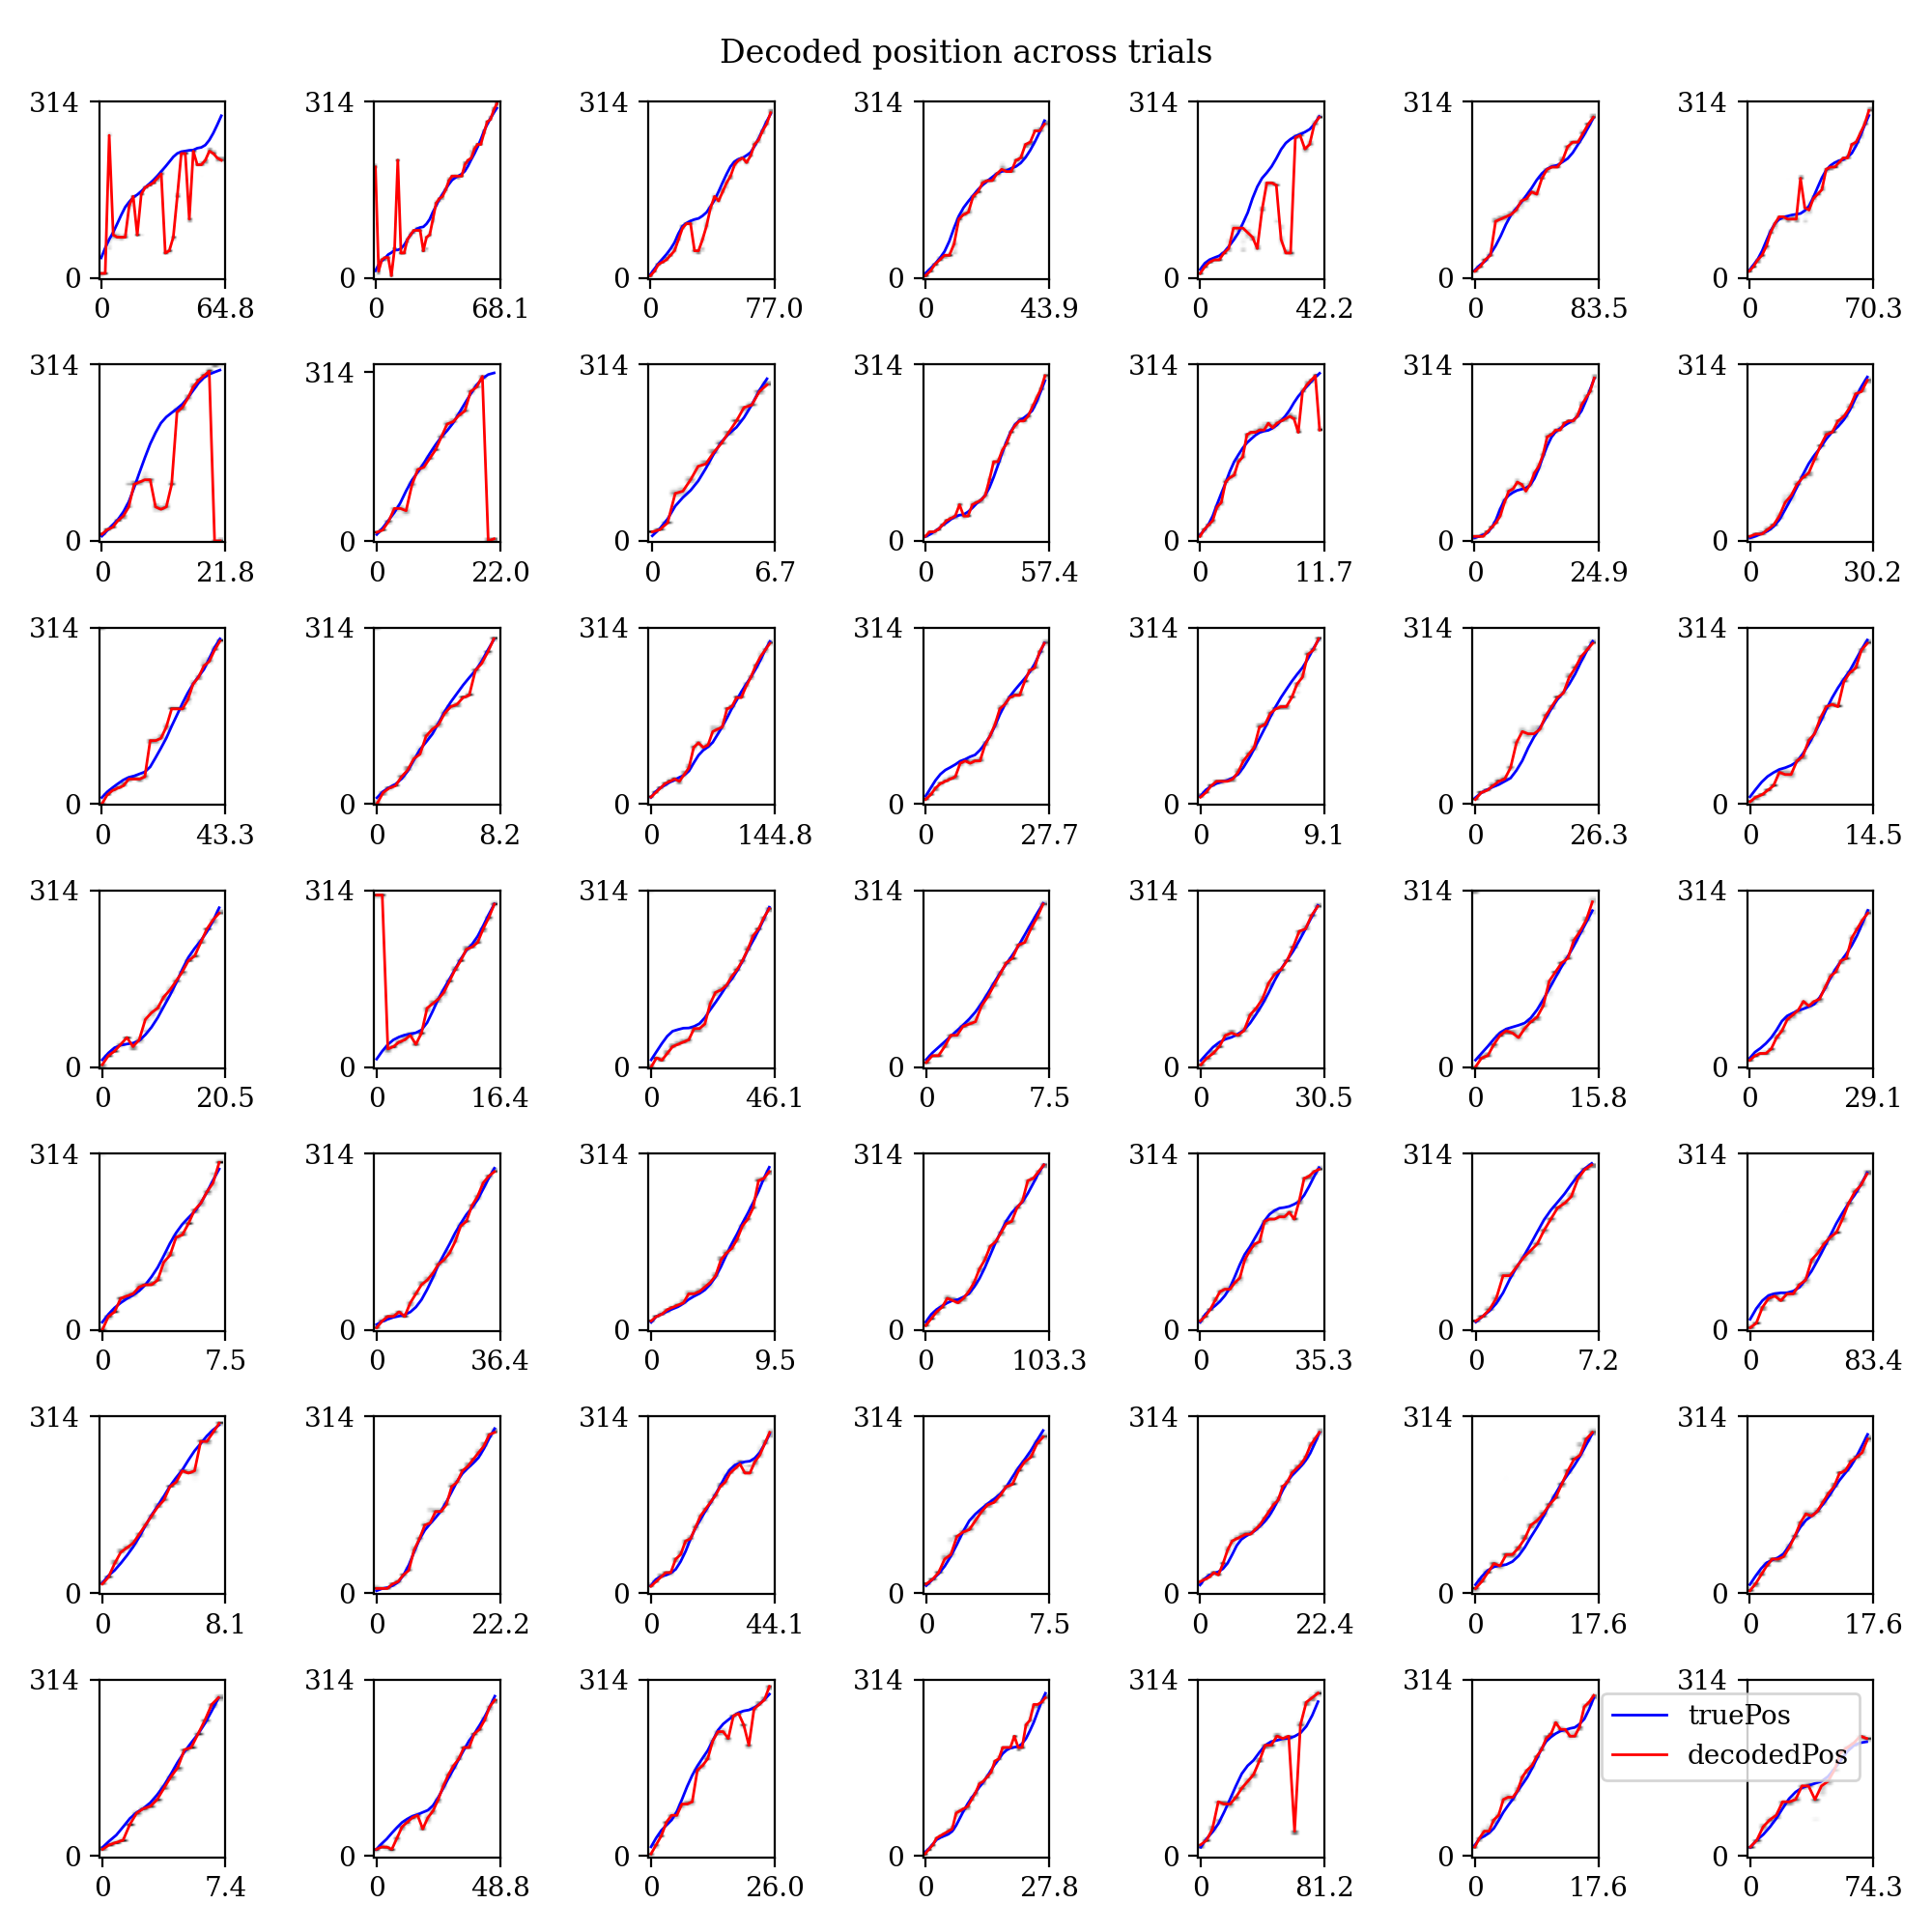

In [15]:
# 1. bayesian decoding error across laps using MLE
posbinwidth = 314.0/popratemap.shape[1]
positionBins = np.arange(popratemap.shape[1],dtype='float32')
posbinswidth = 314./78.
tau = 0.75 # 0.75 second bins
Ntrials = len(trialTs)
truePos = []
decodedPos = []
decodingError = []
plt.figure(figsize=(10, 10))
for j in range(Ntrials):
    nTimeBins = int((trialTs[j][-1]-trialTs[j][0]-1)/tau)
    if nTimeBins>1:
        # compute spike count in each lap
        spkCounts, binwindow = computeSpikeCounts(spktstrial[j], trialTs[j][0], trialTs[j][-1]-1, tau)
        # remove bins with average speed < 5 cm/s and compute center position in each time bin
        binspeed, realPos = calcBinnedStats(binwindow, behavts, speed, pos, tau)
        idx = (np.isnan(binspeed)) | (binspeed<5)
        realPos = np.delete(realPos, idx)
        idx = np.logical_not(idx)
        spkCounts = spkCounts[idx,:]
        # compute likelihood, decoded probability
        likelihood = computeLikelihood(spkCounts, popratemap, tau)
        if likelihood.shape[1]:
            # find max probability location
            index = np.argmax(likelihood, 0)
            decodedX = positionBins[index]
            truePos.append(realPos)
            decodedPos.append(decodedX*posbinwidth)
            # difference between real pos and decoded position is the decoding error
            decodingError.append(np.nanmean(realPos - decodedX*posbinwidth))
            # plot it across laps
            plt.subplot(7,7,j+1)
            plt.imshow(likelihood, origin='lower',aspect='auto',cmap='binary')
            plt.plot(realPos/posbinswidth,c='b',linewidth=1)
            plt.plot(decodedX,c='r',linewidth=1)
            plt.yticks([0,78],[0,314])
            plt.xticks([0,likelihood.shape[1]],[0,round(binwindow[-1]-binwindow[0],1)])
plt.legend(['truePos', 'decodedPos'])
plt.suptitle('Decoded position across trials')  
plt.tight_layout()
plt.show()
truePos = np.array(truePos)
decodedPos = np.array(decodedPos)
decodingError = np.array(decodingError)

<IPython.core.display.Javascript object>


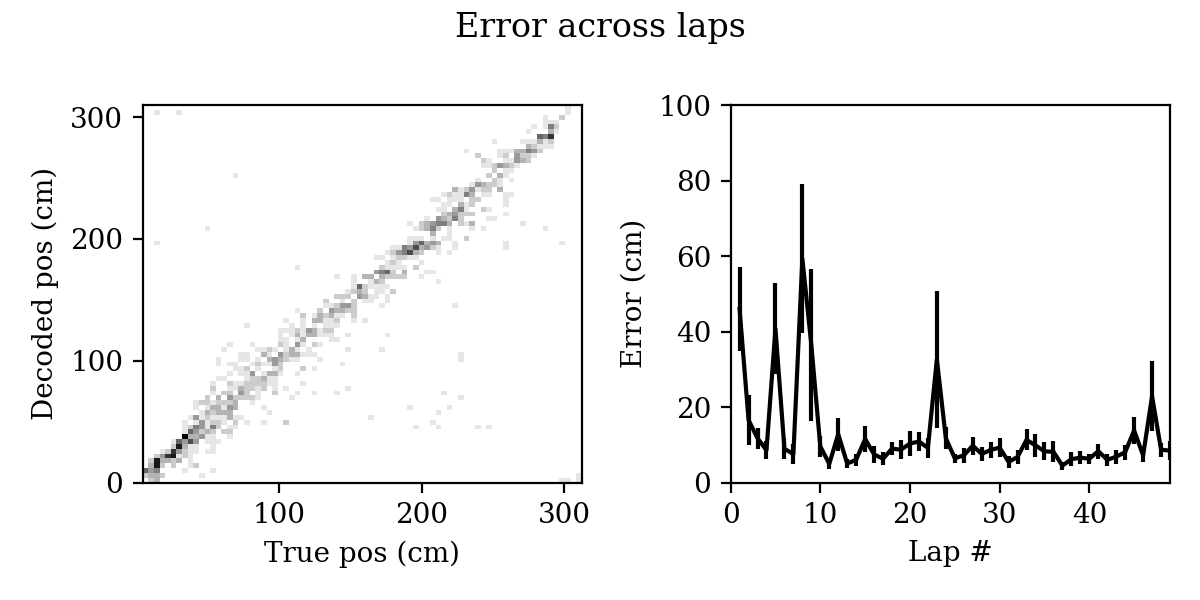

In [16]:
# 2 confusion matrix for each position 
tp = []
dp = []
for t in truePos:
    tp.extend(t)
for d in decodedPos:
    dp.extend(d)
plt.figure(figsize=(6,3))
plt.subplot(121)
# joint probability distribution for real and decoded position
# should be mostly clustered across the diagonal
plt.hist2d(tp,dp,bins=popratemap.shape[1], cmap='binary')
plt.xlabel('True pos (cm)')
plt.ylabel('Decoded pos (cm)')
plt.suptitle('Confusion matrix')
plt.tight_layout()

# decoding error across laps
# linear diff b/w real and decoded position
# should take absolute here, rather than diff alone? 
# for better mean calculation
dE = truePos-decodedPos
errormean = []
errorsem = []
for d in dE:
    errormean.append(np.nanmean(np.abs(d)))
    errorsem.append(spst.sem(d))
errormean = np.array(errormean)
errorsem = np.array(errorsem)
plt.subplot(122)
plt.errorbar(np.arange(len(errormean))+1, errormean, yerr=errorsem, c='k')
plt.ylim([0,100])
plt.xticks(np.arange(0,len(spktstrial),10))
plt.xlim([0,len(spktstrial)])
plt.xlabel('Lap #')
plt.ylabel('Error (cm)')
plt.suptitle('Error across laps')
plt.tight_layout()

plt.show()

# Theta sequence decoding 

In [17]:
# 1. find timestamps for each trough based on population trough angle
# the reference electrode used was mostly in hippcoampus fissure
troughTs = []
for tpk in range(len(thetapeaktime)-1):
    peakdiff = thetapeaktime[tpk+1]-thetapeaktime[tpk]
    if peakdiff>0.1 and peakdiff<0.2:
        troughTs.append(thetapeaktime[tpk] + (peakdiff/360.)*poptroughangle)
troughTs = np.array(troughTs)

In [18]:
# 2. determine speed > 10cm/s theta cycle only points
thetaspeed = []
thetapos = []
# iterate over theta troughs
for t in range(len(troughTs)-1):
    peakdiff = troughTs[t+1]-troughTs[t]
    # theta troughs should be b/w 100-200ms i.e. 5-10Hz (a little low for mouse)
    # for rats, 6-12 Hz
    if peakdiff>=0.1 and peakdiff<=0.2:
        spd = speed[(behavts>=troughTs[t]) & (behavts<=troughTs[t+1])]
        ps = pos[(behavts>=troughTs[t]) & (behavts<=troughTs[t+1])]
        # mean speed and location in each cycle
        if len(spd):
            thetaspeed.append(np.nanmean(spd))
            thetapos.append(np.nanmean(ps))
        else:
            thetaspeed.append(np.nan)
            thetapos.append(np.nan)
    else:
        thetaspeed.append(np.nan)
        thetapos.append(np.nan)
thetaspeed = np.array(thetaspeed)
thetapos = np.array(thetapos)
troughTs = troughTs[:-1]

# theta trough of interest with speed threshold included
# remove points with speed<10cm/s, Feng et a., 2015
# like Foster and Jadhav method for theta sequence detection
rmv_idx = np.where((thetaspeed<10) | np.isnan(thetaspeed))[0]
thetaspeed = np.delete(thetaspeed, rmv_idx)
thetapos = np.delete(thetapos, rmv_idx)
troughTs = np.delete(troughTs, rmv_idx)

In [19]:
# 3. include cells with field in range [10cm,300cm]
idx = np.where((ccenter>5./posbinswidth) & (ccenter<305./posbinswidth))[0]
spktstrialN = []
spkpostrialN = []
for s,p in zip(spktstrial,spkpostrial):
    spktstrialN.append(s[idx])
    spkpostrialN.append(p[idx])
spktstrialN = np.array(spktstrialN)
spkpostrialN = np.array(spkpostrialN)

popratemap = popratemap[idx]
corder = np.argsort(np.argmax(popratemap,1))
ccenter = np.argmax(popratemap,1)
#plt.imshow(popratemap[corder,:], cmap='binary',origin='lower')
#plt.xticks(np.linspace(0,78,5),np.linspace(0,78,5)*4)
#plt.ylabel('Cell #')
#plt.xlabel('position bins (4cm)')
#plt.title('Peak-sorted rate maps')
#plt.show()

24


<IPython.core.display.Javascript object>


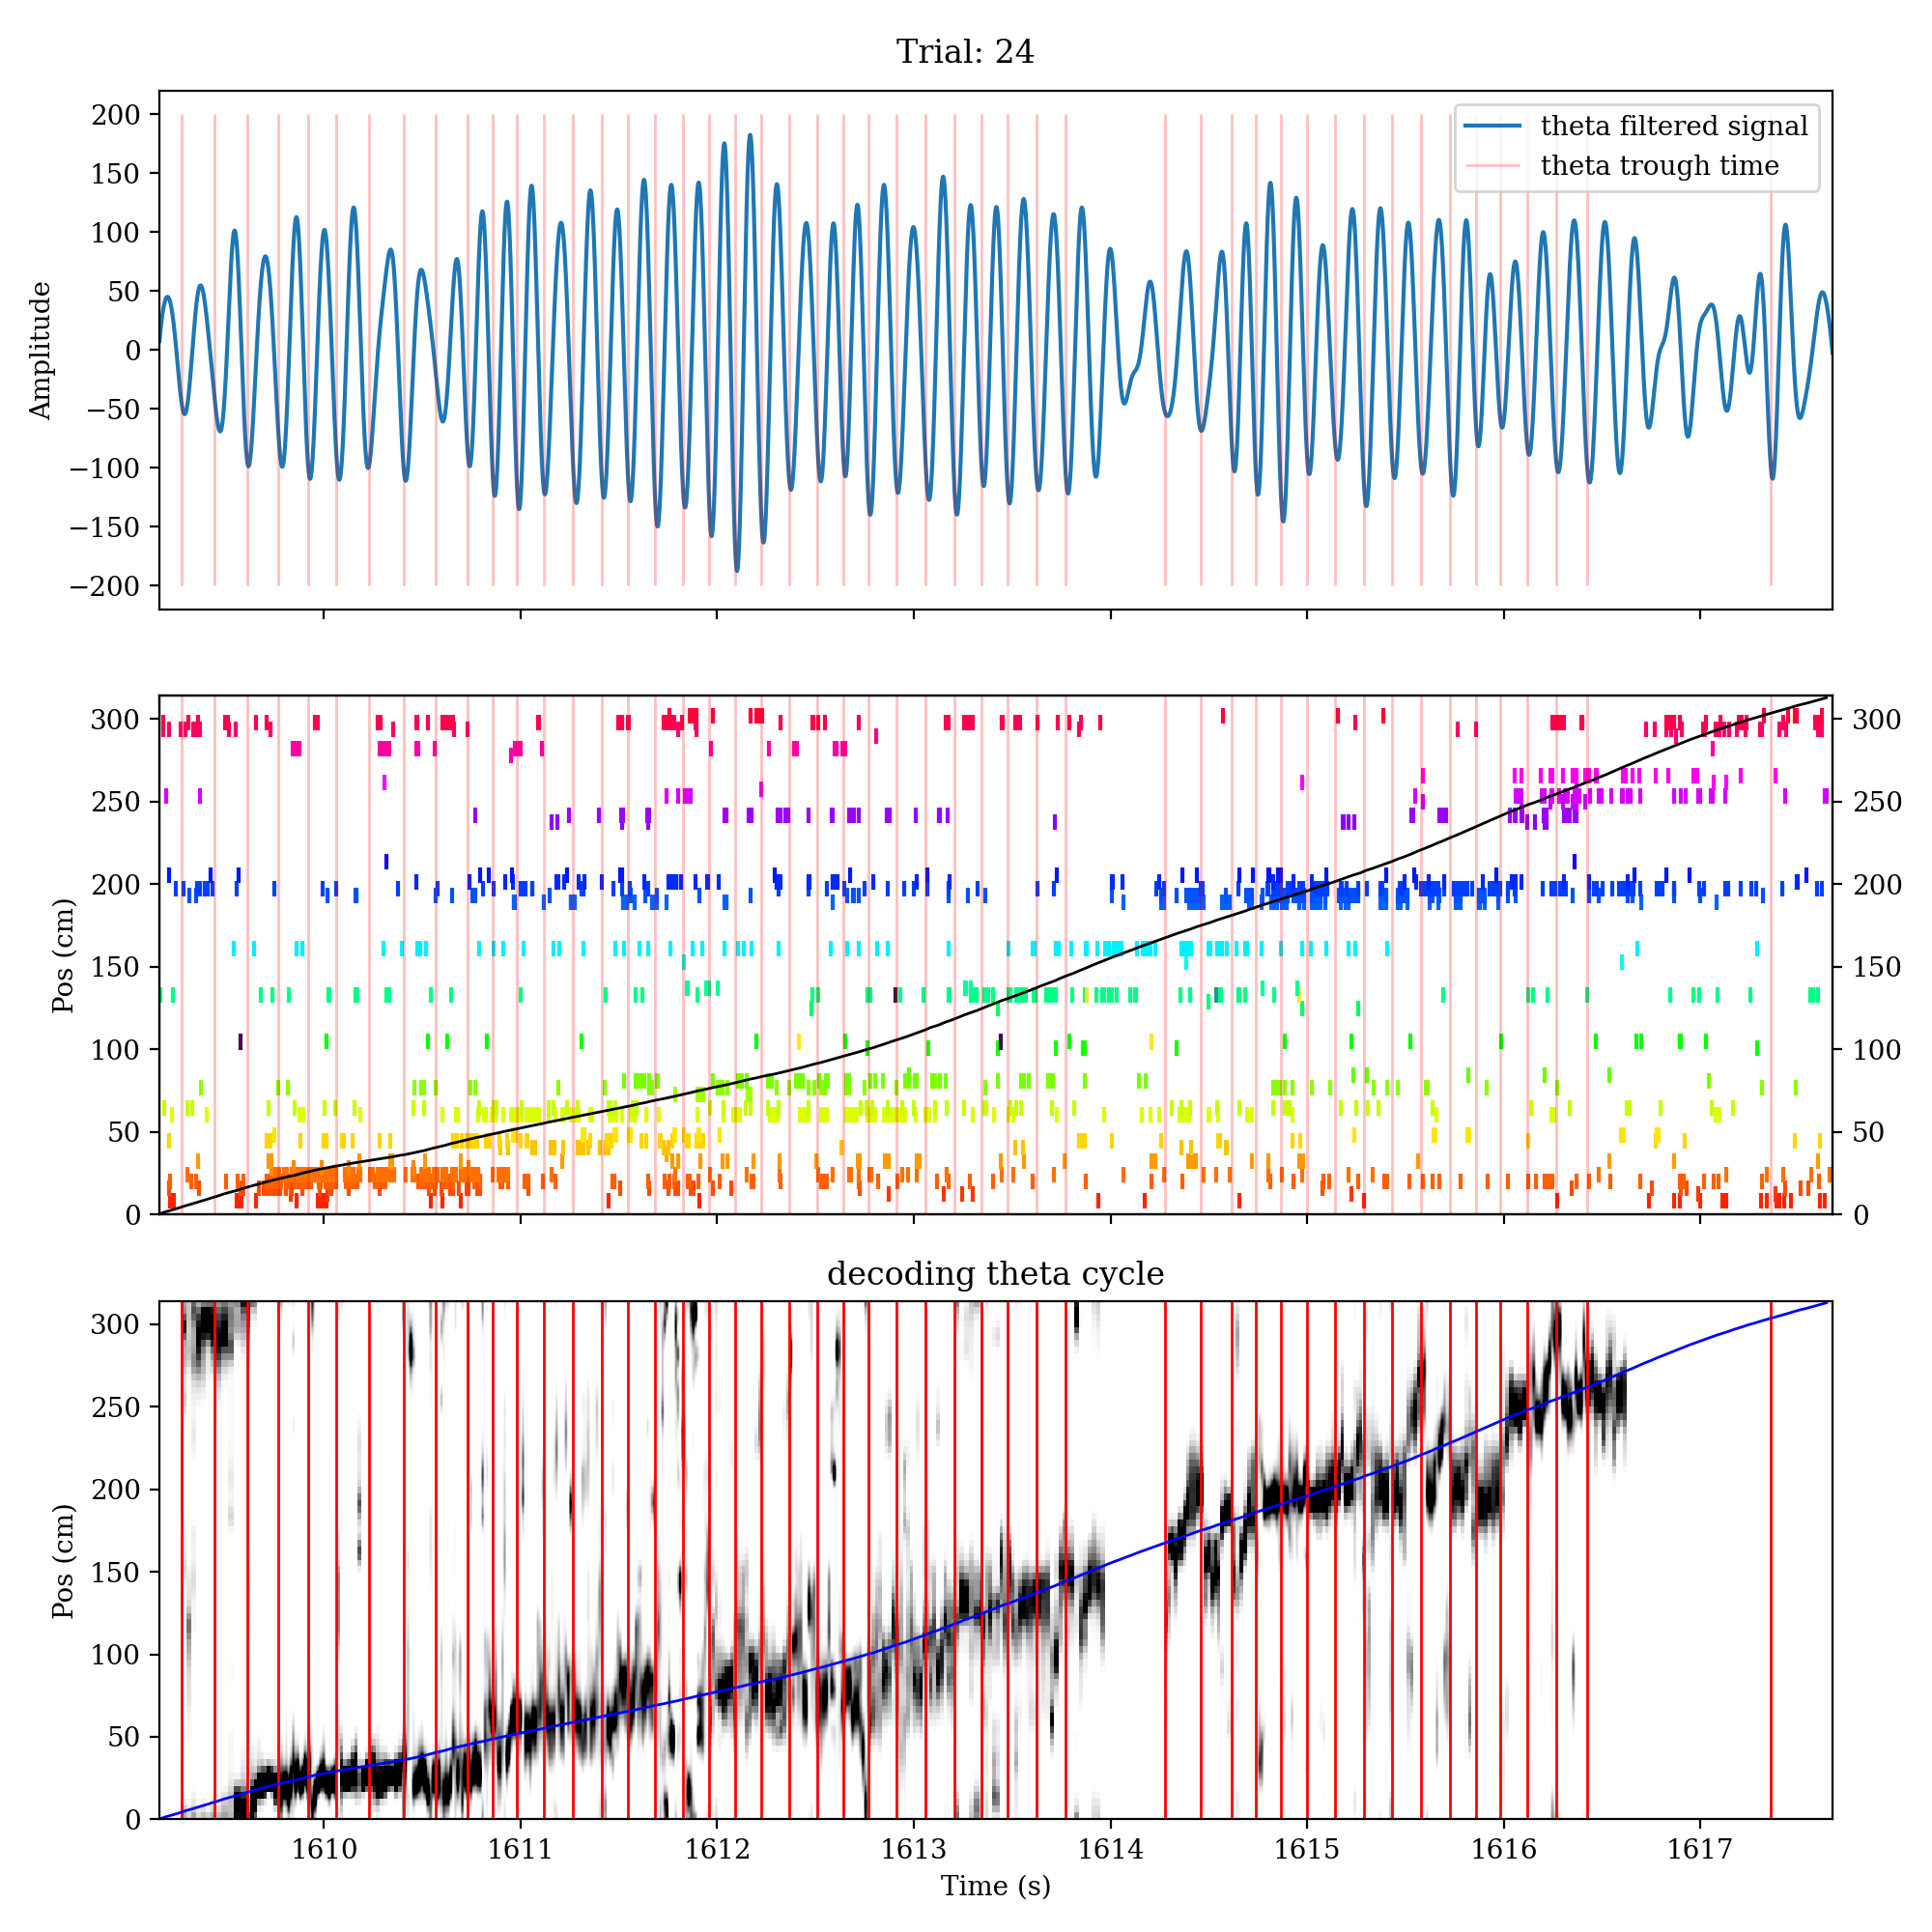

28


<IPython.core.display.Javascript object>


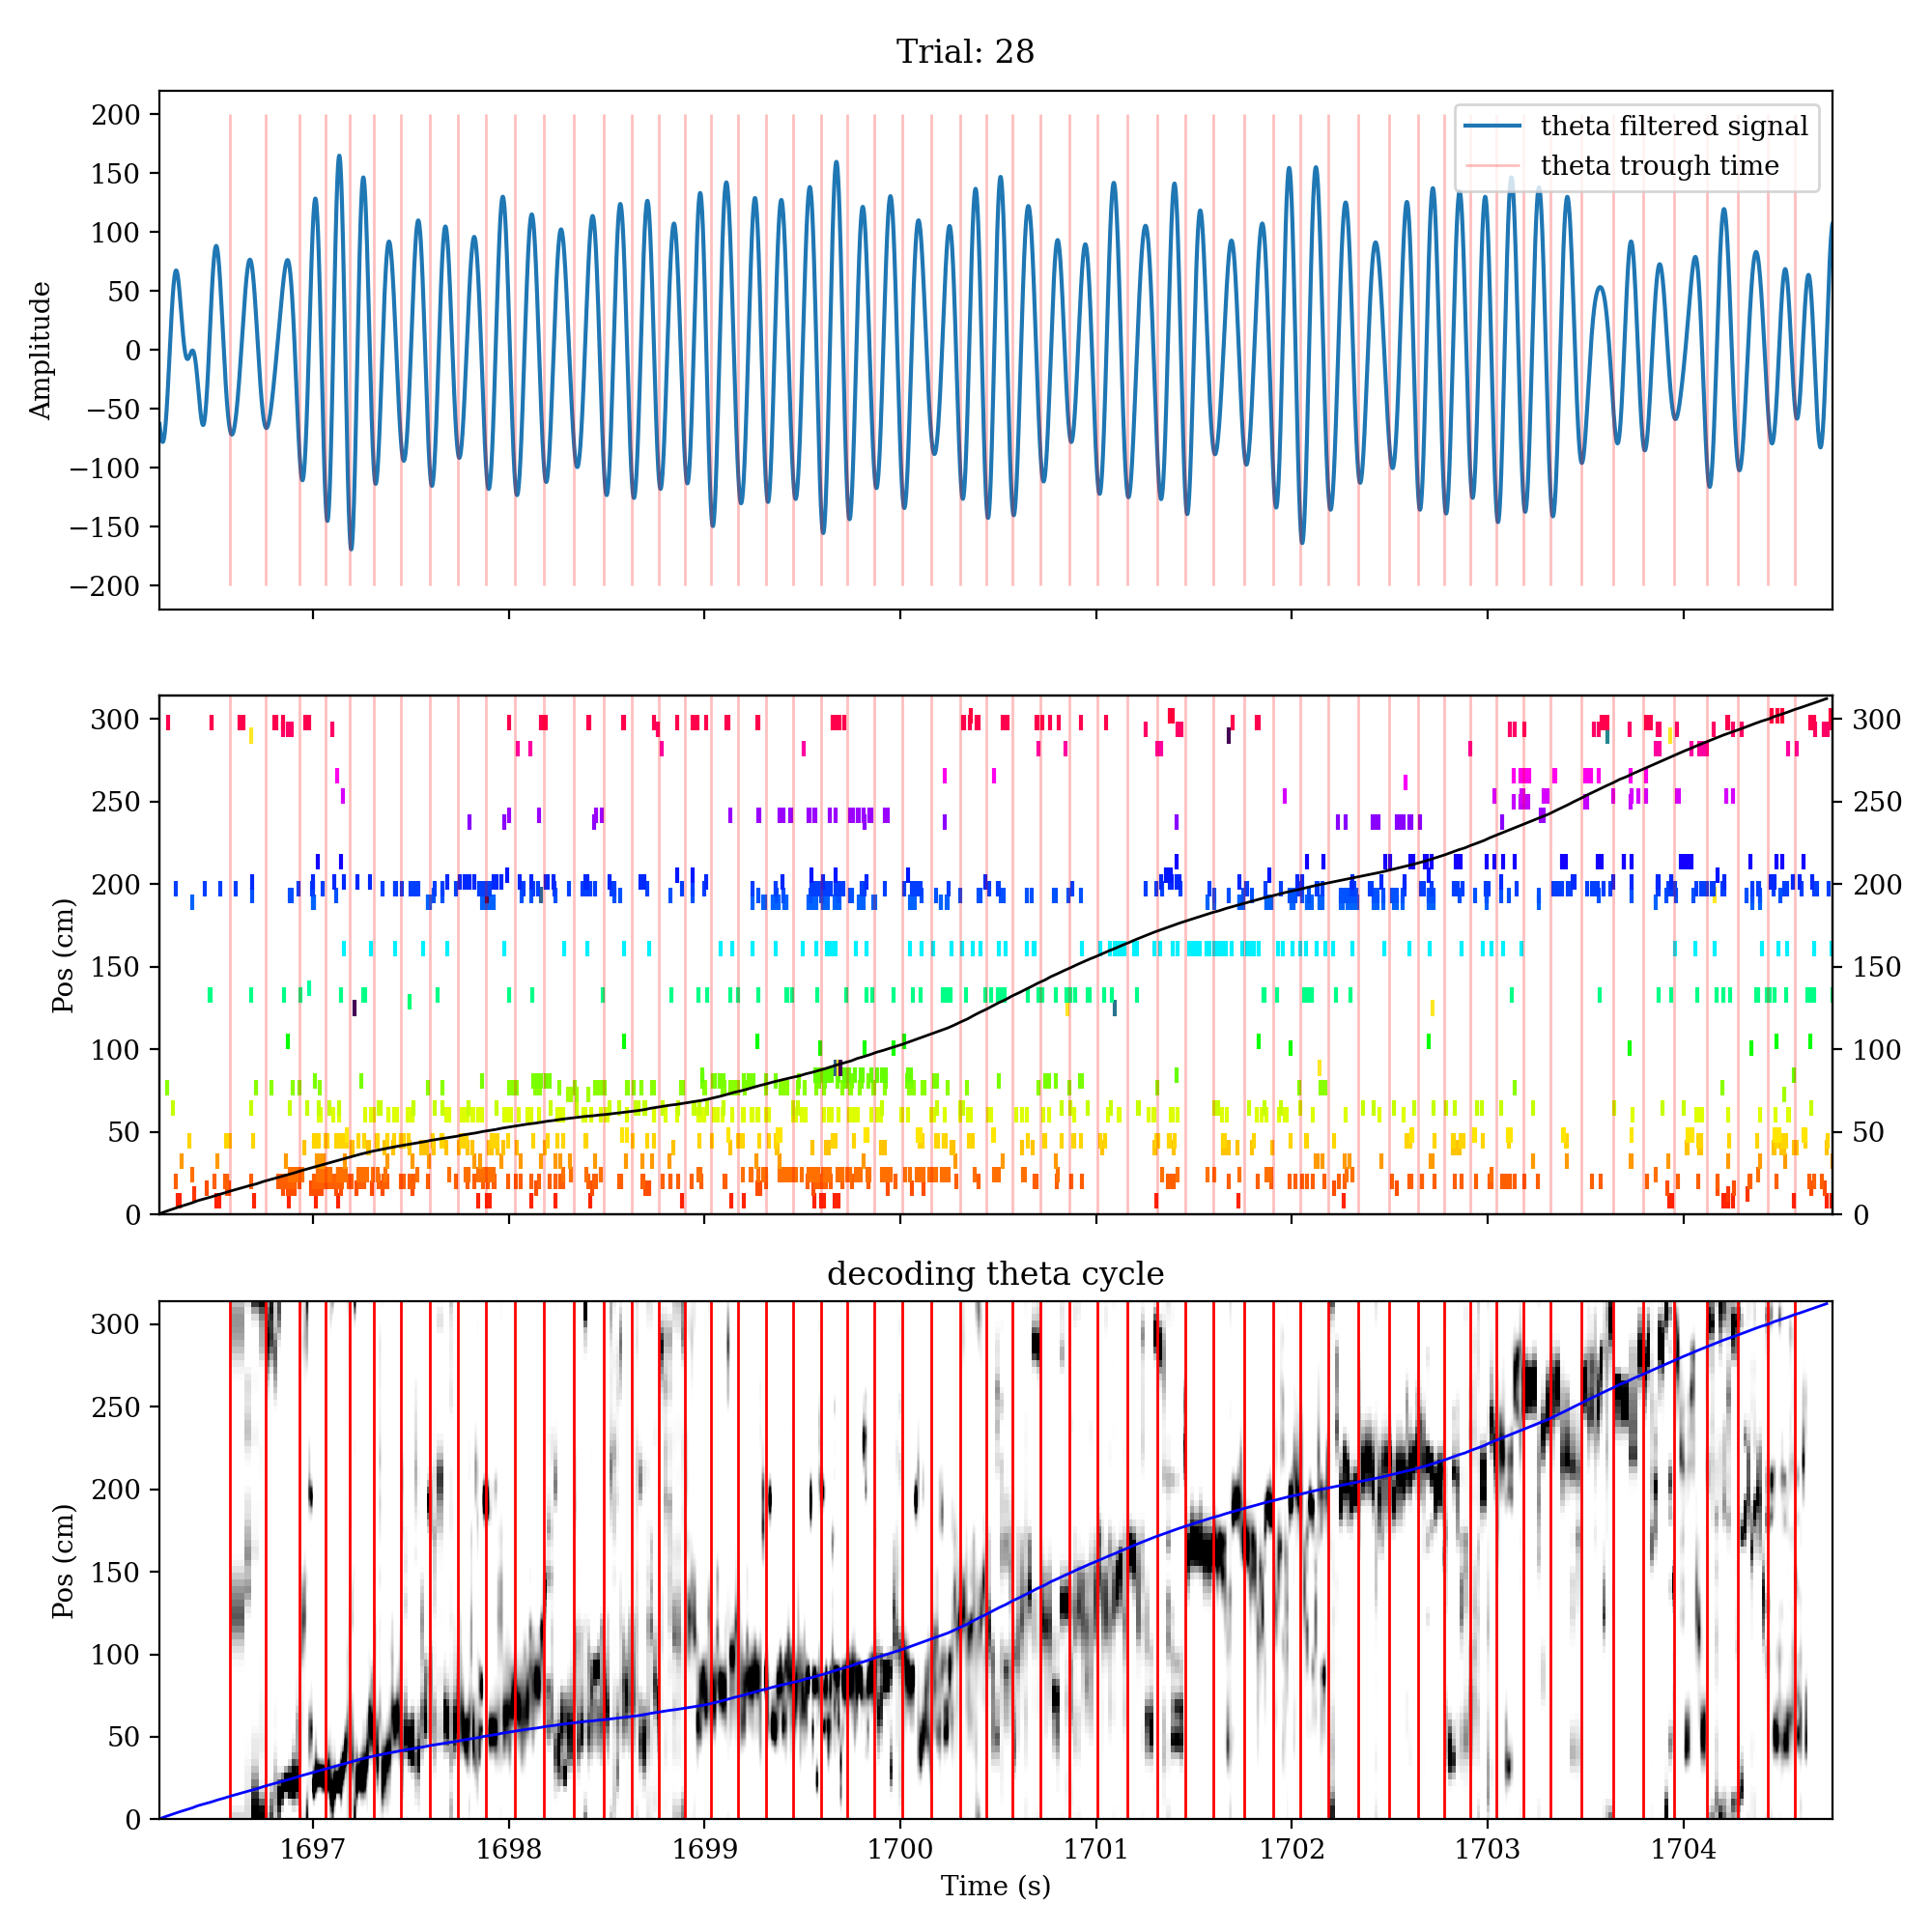

42


<IPython.core.display.Javascript object>


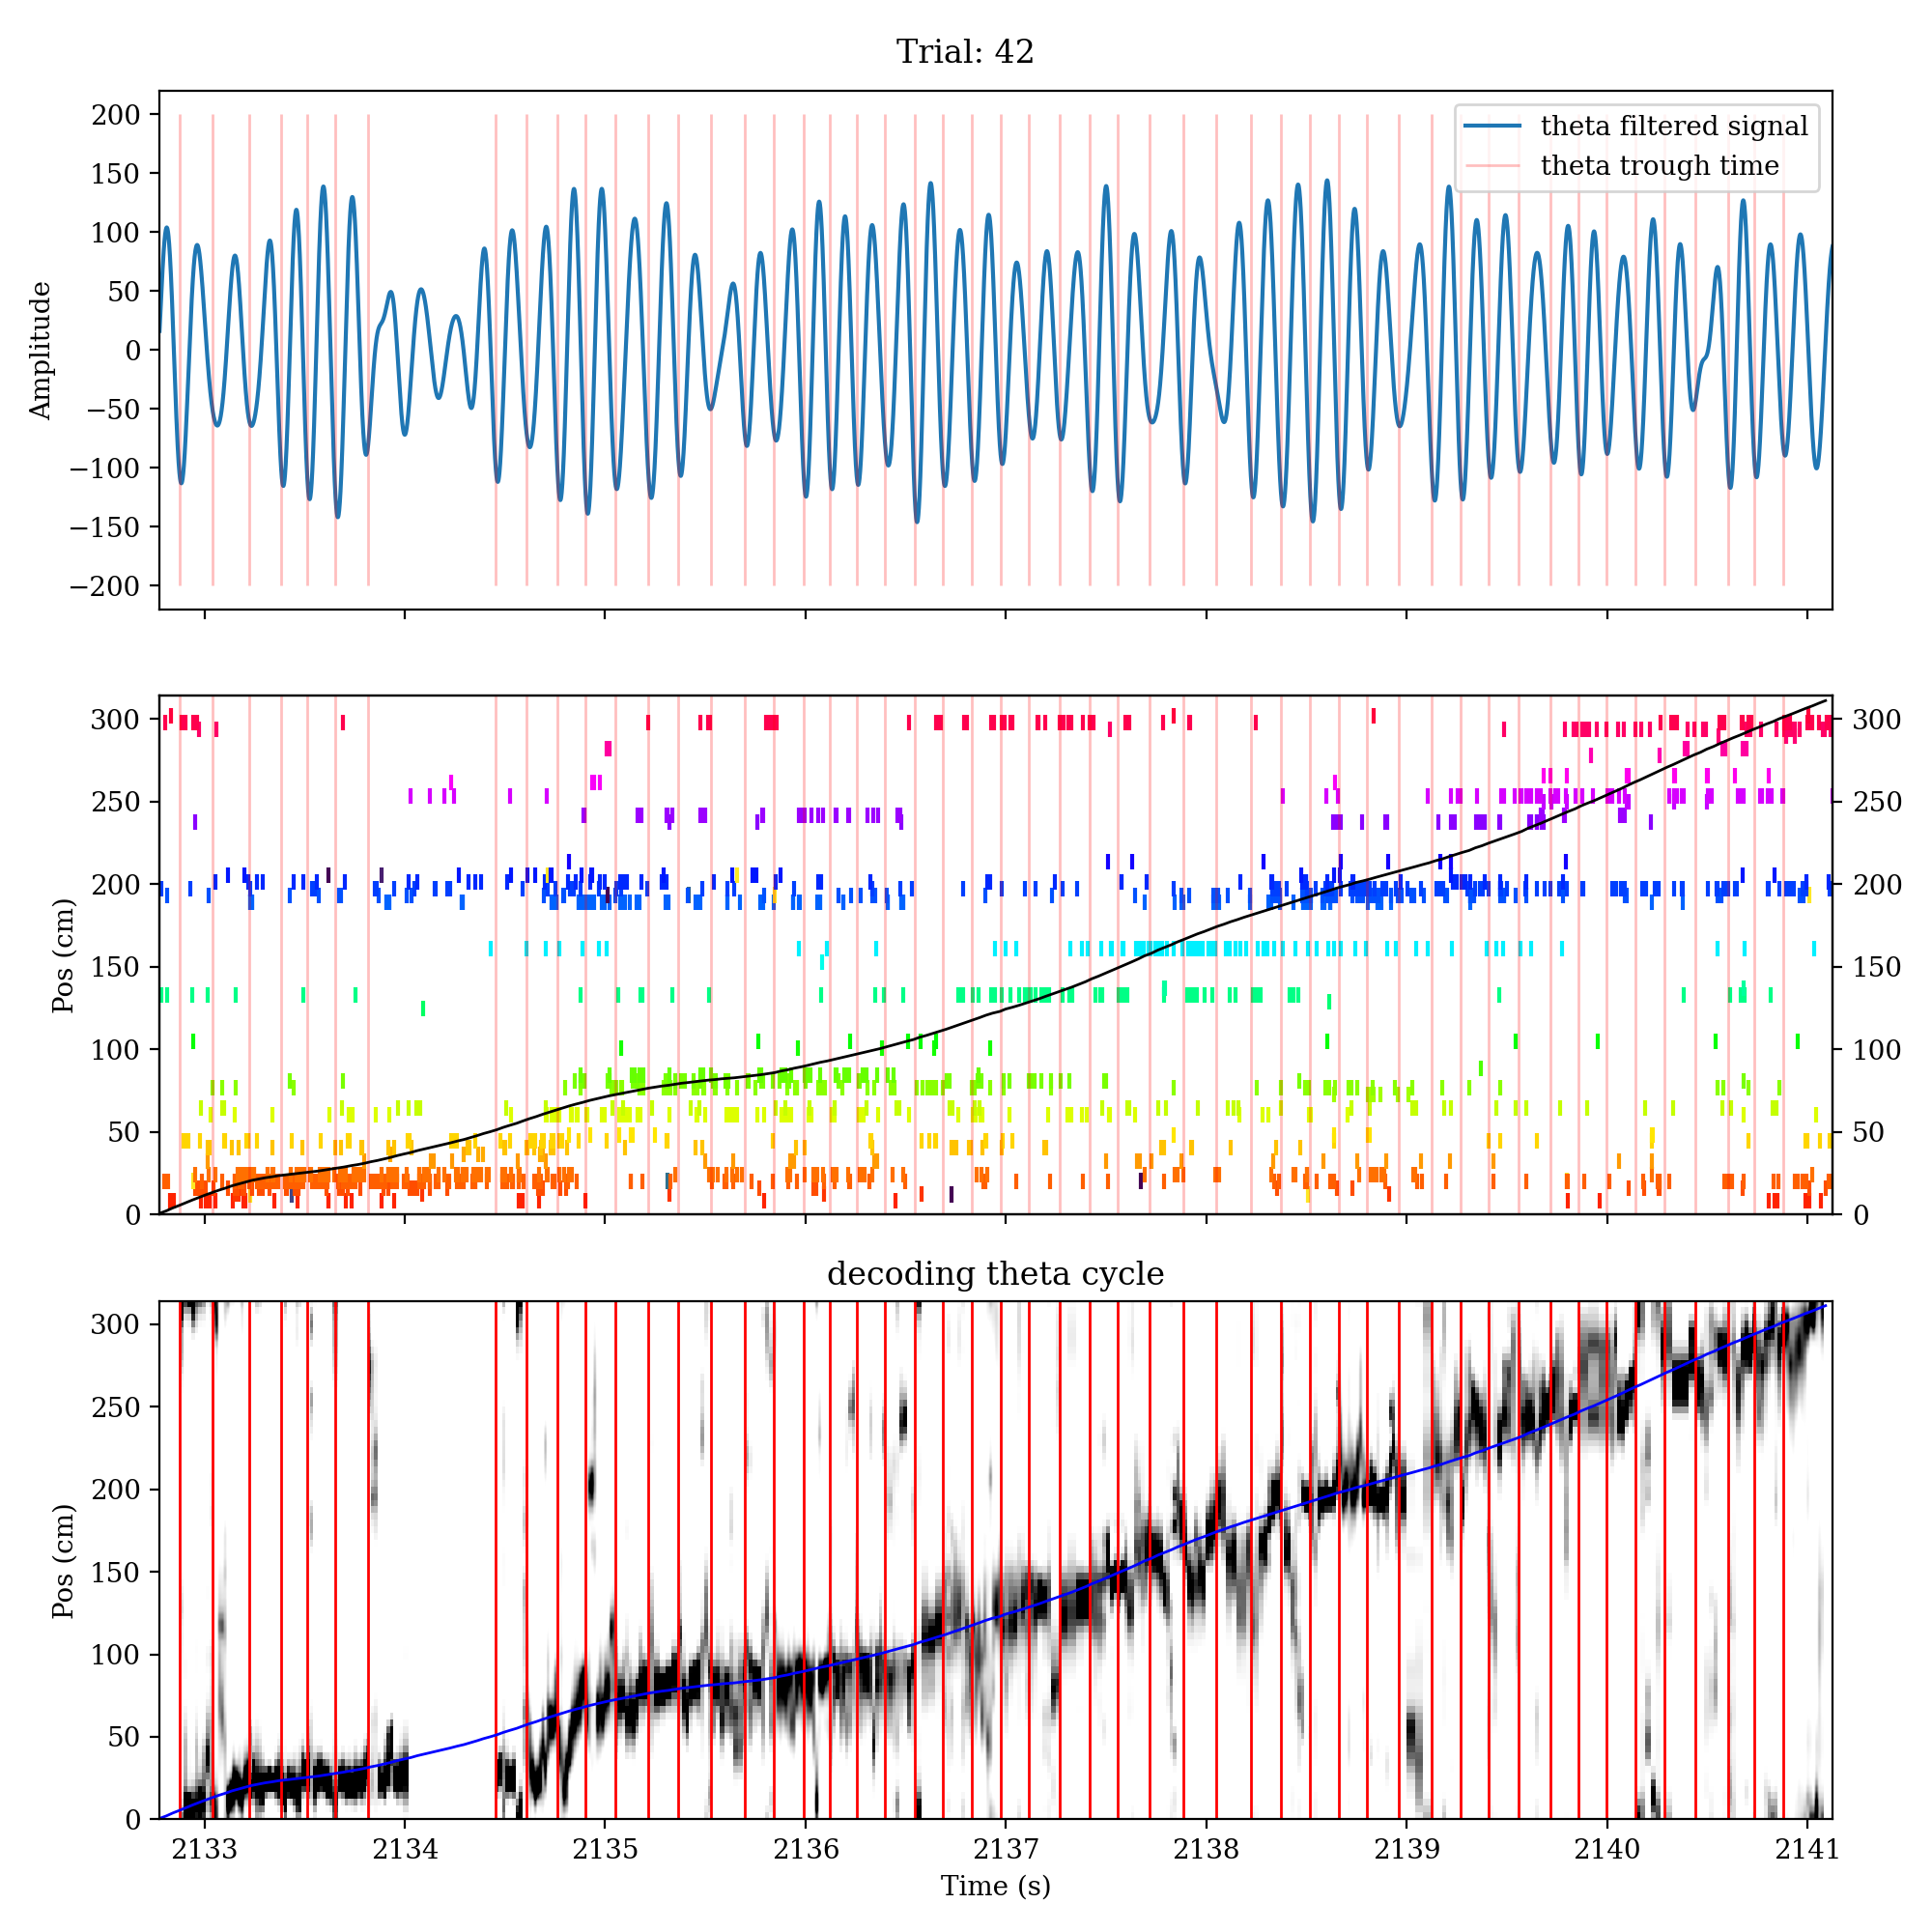

In [20]:
# 3. get decoding eror for each theta cycle
tau=0.02 # 20ms window
colorsc = plt.cm.hsv(np.linspace(0,1,popratemap.shape[1]))
# iterate through trials
for n in [24,28,42]:
    print(n)
    tts = []
    decodedX = []
    postProbTrial = []
    # check for pos b/w [5,305] in each hallway trial
    troughtimes = troughTs[(troughTs>=trialTs[n][0]) & (troughTs<=trialTs[n][-1])]
    postheta = thetapos[(troughTs>=trialTs[n][0]) & (troughTs<=trialTs[n][-1])]
    # iterate over each theta cycle
    for t in range(len(troughtimes)-1):
        if postheta[t]>=5 and postheta[t]<=305:
            # all cell spikes in range [trough, trough+250ms]
            lEdge = troughtimes[t]
            if troughtimes[t+1]-troughtimes[1]<0.2:
                rEdge = troughtimes[t+1]
            else:
                rEdge = troughtimes[t]+0.2
            spktstheta = []
            for spk in spktstrialN[n]:
                spktstheta.append(spk[np.where((spk>=lEdge) & (spk<rEdge))[0]])
            spktstheta = np.array(spktstheta)
            # compute spike counts for 20ms window, 10ms overlap
            spkCounts, _ = computeSpikeCounts(spktstheta, lEdge, rEdge, tau)
            # include total active cell >= 5
            nCellsActive = np.nansum(np.nansum(spkCounts,0)>0)
            if nCellsActive>=5:
                # compute likelihood (posterior probability)
                likelihood = computeLikelihood(spkCounts, popratemap, tau)
                # remove 0 sum bins
                likelihood = likelihood[:,np.nansum(spkCounts,1)>2]
                tts.append([lEdge, rEdge])
                # index of max decoded probability
                index = np.argmax(likelihood, 0)
                decodedpos = positionBins[index]*posbinswidth
                decodedX.append(decodedpos)
                postProbTrial.append(likelihood)
    #postProbTrial = np.hstack(postProbTrial)
    tts = np.array(tts)
    
    spiketimestrial = spktstrialN[n][corder]
    spikepostrial = spkpostrialN[n][corder]
    fig, ax = plt.subplots(nrows=3, ncols=1,figsize=(10,10),sharex=True)
    indS = np.where(times>=trialTs[n][0])[0][0]
    indE = np.where(times<=trialTs[n][-1])[0][-1]
    ax[0].plot(times[indS:indE],sig_filt[indS:indE])
    indST = np.where(troughTs>=trialTs[n][0])[0][0]
    indET = np.where(troughTs<=trialTs[n][-1])[0][-1]
    ax[0].vlines(troughTs[indST:indET],ymin=-200,ymax=200, color='r', 
                 alpha=0.25,linewidth=1)
    ax[0].set_ylabel('Amplitude')
    ax[0].legend(['theta filtered signal', 'theta trough time'])
    for i, (spiketrain, spikepos) in enumerate(zip(spiketimestrial,spikepostrial)):
        y=posbinswidth*ccenter[corder][i] * np.ones_like(spikepos)
        ax[1].scatter(spiketrain, y, c=colorsc[ccenter[corder][i]], marker='|')
    ax[1].vlines(troughTs[indST:indET],ymin=0, ymax=popratemap.shape[0]*posbinswidth, 
                 color='r', alpha=0.25,linewidth=1)
    ax[1].set_xlim([trialTs[n][0], trialTs[n][-1]])
    ax[1].set_ylabel('Pos (cm)')
    ax[1].set_ylim([0,314])
    ax2 = ax[1].twinx()
    indS = np.where(behavts>=trialTs[n][0])[0][0]
    indE = np.where(behavts<=trialTs[n][-1])[0][-1]
    ax2.plot(behavts[indS:indE],pos[indS:indE],'k',linewidth=1)
    ax2.set_ylim([0,314])
    for prob,ts,decX in zip(postProbTrial,tts,decodedX):
        ax[2].imshow(prob, aspect='auto',origin='lower',vmin=4e-3,vmax=0.1, cmap='binary',
                     extent=[ts[0],ts[-1],0,popratemap.shape[1]*posbinswidth])
        #ax[2].plot(np.linspace(ts[0],ts[-1],len(decX)), decX, 'r')
    ax[2].vlines(troughTs[indST:indET], ymin=0, ymax=popratemap.shape[1]*posbinswidth, 
                 color='r',linewidth=1)
    ax[2].plot(behavts[indS:indE],pos[indS:indE],'b',linewidth=1)
    #ax[2].set_xlim([None,1617])
    ax[2].set_xlabel('Time (s)')
    ax[2].set_ylabel('Pos (cm)')
    ax[2].set_title('decoding theta cycle')
    plt.suptitle('Trial: ' + str(n))
    plt.tight_layout()
    plt.show()